# Interaction 1: Initial Setup and Imports

## Instructions
- Import necessary libraries for data analysis and visualization.
- Libraries include `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`, and `yfinance`.


# Interaction 2: Download Financial Data

## Instructions
- Define the stock ticker (e.g., 'AAPL' for Apple).
- Use `yfinance` to download financial statements: income statement, balance sheet, and cash flow.
- Transpose the data for better readability.



# Interaction 3: Data Cleaning

## Instructions
- Convert data to numeric format, coercing errors to NaN.
- Fill missing values with 0 to handle NaN entries.



# Interaction 4: Compute Key Financial Ratios

## Instructions
- Compute key financial ratios including:
  - Liquidity Ratios: Current Ratio, Quick Ratio
  - Profitability Ratios: Net Profit Margin, ROA, ROE
  - Leverage Ratios: Debt-to-Equity, Interest Coverage
- Note: In this example, we compute a subset of these ratios due to available data.



In [5]:
# Ensure numeric values for calculations

# Current Ratio = Current Assets / Current Liabilities

# Quick Ratio = (Current Assets - Inventory) / Current Liabilities

# Debt-to-Equity Ratio = Total Debt / Stockholders Equity

# Debt-to-Asset Ratio = Total Debt / Total Assets

# Return on Equity (ROE) = Retained Earnings / Stockholders Equity (Note: Using Retained Earnings as a proxy)

# Return on Assets (ROA) = Retained Earnings / Total Assets (Note: Using Retained Earnings as a proxy)

# Display updated DataFrame with new ratios

# Interaction 5: Visualize Financial Trends

## Instructions
- Define key financial ratios to visualize.
- Create a boxplot to analyze outliers in the financial ratios.
- Customize the plot with a figure size, title, and rotated x-axis labels.


# Interaction 6: Project Insights

## Instructions
- Summarize the insights gained from the project.
- Highlight the analysis of financial health, visualization, data cleaning, and classification.

## Text
**Insights from this Project**

- ✅ Analyzed financial health using ratios
- ✅ Visualized distributions and correlations
- ✅ Handled missing values and removed outliers
- ✅ Classified companies into risk categories

# Interaction 7: Results & Insights

## Instructions
- Provide a detailed summary of results and insights.
- Emphasize key findings related to financial ratios, visualization, outlier handling, and risk classification.

## Text
**Results & Insights**

- 🔹 Financial ratios revealed risk levels & profitability of companies
- 🔹 Data visualization provided clear patterns in financial health
- 🔹 Outlier removal improved analysis accuracy
- 🔹 Financial health classification grouped companies into risk categories

## Setup and ratio engine for Samsung

In [6]:
import warnings, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import yfinance as yf

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["legend.frameon"] = False

TICKER = "005930.KS"  # Samsung Electronics on KRX [web:72]

# ---------- helper to pick first available column ----------
def pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return df[c]
    return pd.Series(index=df.index, dtype="float64")

# ---------- pull statements ----------
def get_statements(ticker=TICKER):
    t = yf.Ticker(ticker)
    inc = t.financials.T.copy()
    bs  = t.balance_sheet.T.copy()
    cf  = t.cashflow.T.copy()

    for df_ in (inc, bs, cf):
        for c in df_.columns:
            df_[c] = pd.to_numeric(df_[c], errors="coerce")
        df_.fillna(0, inplace=True)
    return inc, bs, cf

# ---------- compute Samsung ratios ----------
def compute_samsung_ratios(ticker=TICKER):
    inc, bs, cf = get_statements(ticker)

    # Income statement
    revenue    = pick(inc, ["Total Revenue", "Revenue"])
    net_income = pick(inc, ["Net Income", "NetIncome"])
    oper_inc   = pick(inc, ["Operating Income", "OperatingIncome", "EBIT"])
    int_exp    = pick(inc, ["Interest Expense", "Interest Expense Non Operating", "InterestExpense"])

    # Balance sheet
    curr_assets = pick(bs, ["Total Current Assets", "Current Assets"])
    curr_liab   = pick(bs, ["Total Current Liabilities", "Current Liabilities"])
    inventory   = pick(bs, ["Inventory"])
    tot_assets  = pick(bs, ["Total Assets"])
    tot_equity  = pick(bs, ["Total Stockholder Equity", "Total Shareholder Equity", "Stockholders Equity"])
    # total debt = short + long term debt (robust definition) [web:58]
    short_debt  = pick(bs, ["Short Long Term Debt", "Short Term Debt", "Current Debt"])
    long_debt   = pick(bs, ["Long Term Debt", "Long Term Debt Noncurrent"])
    total_debt  = short_debt + long_debt

    # Frame aligned by period
    df = pd.DataFrame(index=inc.index)
    df["Revenue"]    = revenue
    df["NetIncome"]  = net_income
    df["OperatingIncome"] = oper_inc
    df["InterestExpense"] = int_exp
    df["CurrAssets"] = curr_assets
    df["CurrLiab"]   = curr_liab
    df["Inventory"]  = inventory
    df["TotAssets"]  = tot_assets
    df["TotEquity"]  = tot_equity
    df["TotalDebt"]  = total_debt

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # keep only years with core fields
    core_mask = df[["Revenue", "NetIncome", "TotAssets", "TotEquity"]].replace(0, np.nan).notna().all(axis=1)
    df = df.loc[core_mask].sort_index()

    # ROA / ROE on average balances (ROAA / ROAE) [web:52][web:65]
    df["AvgAssets"] = (df["TotAssets"] + df["TotAssets"].shift(1)) / 2
    df["AvgEquity"] = (df["TotEquity"] + df["TotEquity"].shift(1)) / 2
    df["AvgAssets"].fillna(df["TotAssets"], inplace=True)
    df["AvgEquity"].fillna(df["TotEquity"], inplace=True)

    ratios = pd.DataFrame(index=df.index)

    # Liquidity
    ratios["Current_Ratio"] = (df["CurrAssets"] / df["CurrLiab"]).replace([np.inf, -np.inf], np.nan)
    ratios["Quick_Ratio"]   = ((df["CurrAssets"] - df["Inventory"]) / df["CurrLiab"]).replace([np.inf, -np.inf], np.nan)

    # Profitability
    ratios["Net_Profit_Margin"] = (df["NetIncome"] / df["Revenue"]).replace([np.inf, -np.inf], np.nan)
    ratios["ROA"] = (df["NetIncome"] / df["AvgAssets"]).replace([np.inf, -np.inf], np.nan)
    ratios["ROE"] = (df["NetIncome"] / df["AvgEquity"]).replace([np.inf, -np.inf], np.nan)

    # Leverage and coverage
    ratios["Debt_to_Equity"] = (df["TotalDebt"] / df["TotEquity"]).replace([np.inf, -np.inf], np.nan)
    ratios["Interest_Coverage"] = (
        df["OperatingIncome"] / df["InterestExpense"].abs().replace(0, np.nan)
    ).replace([np.inf, -np.inf], np.nan)

    # DuPont: ROE = NPM × AT × EM [web:57][web:60]
    ratios["NPM"] = ratios["Net_Profit_Margin"]
    ratios["AT"]  = (df["Revenue"] / df["AvgAssets"]).replace([np.inf, -np.inf], np.nan)
    ratios["EM"]  = (df["AvgAssets"] / df["AvgEquity"]).replace([np.inf, -np.inf], np.nan)
    ratios["ROE_DuPont"] = ratios["NPM"] * ratios["AT"] * ratios["EM"]

    ratios["Ticker"] = ticker
    return ratios

samsung_ratios = compute_samsung_ratios()
print("Samsung ratios (latest first):")
display(samsung_ratios.iloc[::-1].round(3))

Samsung ratios (latest first):


,Current_Ratio,Quick_Ratio,Net_Profit_Margin,ROA,ROE,Debt_to_Equity,Interest_Coverage,NPM,AT,EM,ROE_DuPont,Ticker
2024-12-31,2.433,1.878,0.112,0.069,0.090,0.037,36.205,0.112,0.620,1.303,0.090,005930.KS
2023-12-31,2.588,1.906,0.056,0.032,0.041,0.023,7.059,0.056,0.573,1.295,0.041,005930.KS
2022-12-31,2.789,2.122,0.181,0.125,0.171,0.017,56.849,0.181,0.691,1.364,0.171,005930.KS
2021-12-31,2.476,2.006,0.140,0.092,0.132,0.050,119.650,0.140,0.655,1.440,0.132,005930.KS


## Vizualizations

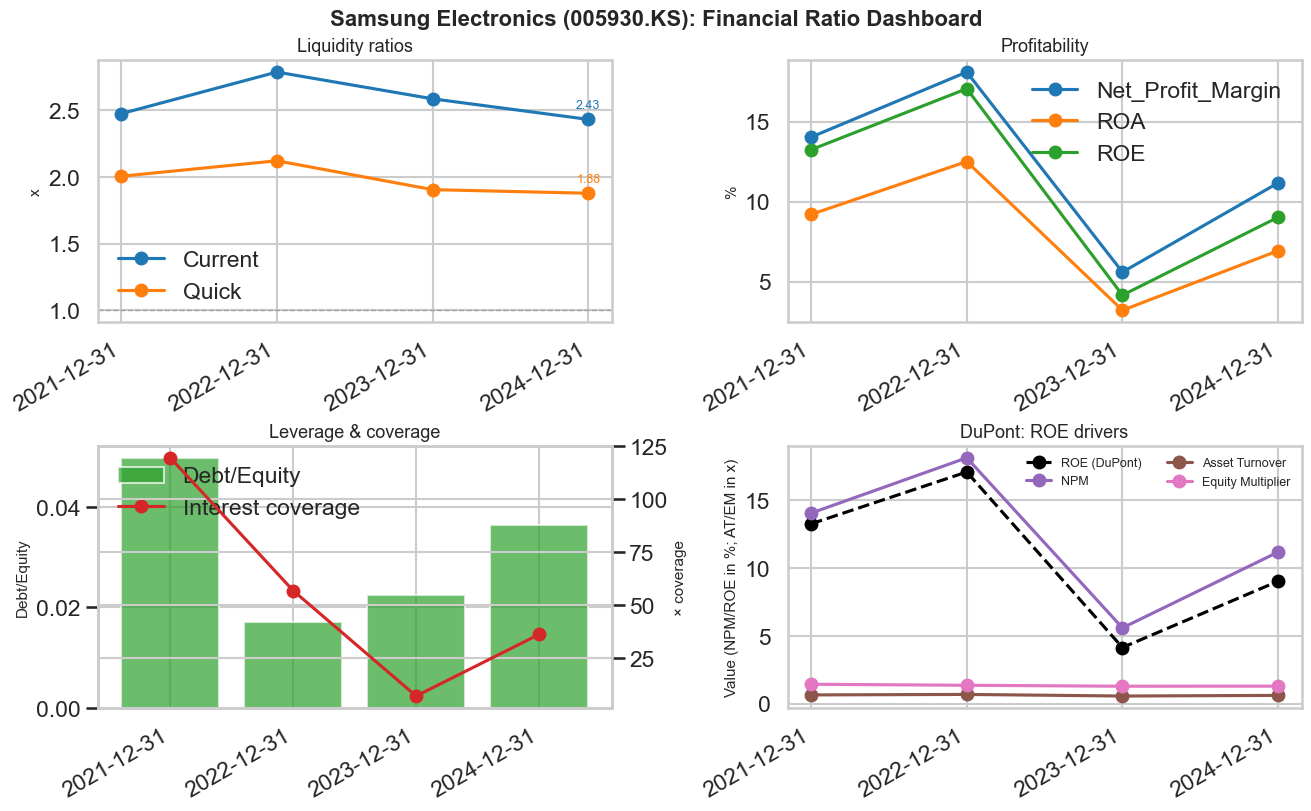

In [7]:
sub = samsung_ratios.copy().sort_index()
periods = sub.index.strftime("%Y-%m-%d")  # for nicer x‑labels

# ---------- 2x2 dashboard ----------
palette = sns.color_palette("tab10")

fig, axes = plt.subplots(2, 2, figsize=(13, 8), constrained_layout=True)
fig.suptitle("Samsung Electronics (005930.KS): Financial Ratio Dashboard", fontsize=16, weight="bold")

# 1) Liquidity
ax = axes[0, 0]
ax.plot(periods, sub["Current_Ratio"], marker="o", color=palette[0], label="Current")
ax.plot(periods, sub["Quick_Ratio"], marker="o", color=palette[1], label="Quick")
ax.axhline(1.0, color="gray", linestyle="--", linewidth=1, alpha=0.6)
ax.set_title("Liquidity ratios")
ax.set_ylabel("x")
ax.set_xticklabels(periods, rotation=30, ha="right")
ax.legend()

# annotate latest
if not sub.empty:
    x_last = periods[-1]
    for col, col_color in [("Current_Ratio", palette[0]), ("Quick_Ratio", palette[1])]:
        y_last = sub[col].iloc[-1]
        ax.annotate(f"{y_last:.2f}", xy=(x_last, y_last),
                    xytext=(0, 8), textcoords="offset points",
                    ha="center", color=col_color, fontsize=9)

# 2) Profitability (as percentages)
ax = axes[0, 1]
for i, col in enumerate(["Net_Profit_Margin", "ROA", "ROE"]):
    ax.plot(periods, 100 * sub[col], marker="o", label=col, color=palette[i])
ax.set_title("Profitability")
ax.set_ylabel("%")
ax.set_xticklabels(periods, rotation=30, ha="right")
ax.legend()

# 3) Leverage vs interest coverage
ax = axes[1, 0]
ax2 = ax.twinx()
ax.bar(periods, sub["Debt_to_Equity"], color=palette[2], alpha=0.7, label="Debt/Equity")
ax2.plot(periods, sub["Interest_Coverage"], marker="o", color=palette[3], label="Interest coverage")

ax.set_title("Leverage & coverage")
ax.set_ylabel("Debt/Equity")
ax2.set_ylabel("× coverage")
ax.set_xticklabels(periods, rotation=30, ha="right")

# custom legend combining both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# 4) DuPont components
ax = axes[1, 1]
ax.plot(periods, 100 * sub["ROE_DuPont"], marker="o", linestyle="--", color="black", label="ROE (DuPont)")
ax.plot(periods, 100 * sub["NPM"], marker="o", color=palette[4], label="NPM")
ax.plot(periods, sub["AT"], marker="o", color=palette[5], label="Asset Turnover")
ax.plot(periods, sub["EM"], marker="o", color=palette[6], label="Equity Multiplier")

ax.set_title("DuPont: ROE drivers")
ax.set_ylabel("Value (NPM/ROE in %; AT/EM in x)")
ax.set_xticklabels(periods, rotation=30, ha="right")
ax.legend(ncol=2, fontsize=9)

plt.show()

## Samsung's latest year ratio profile

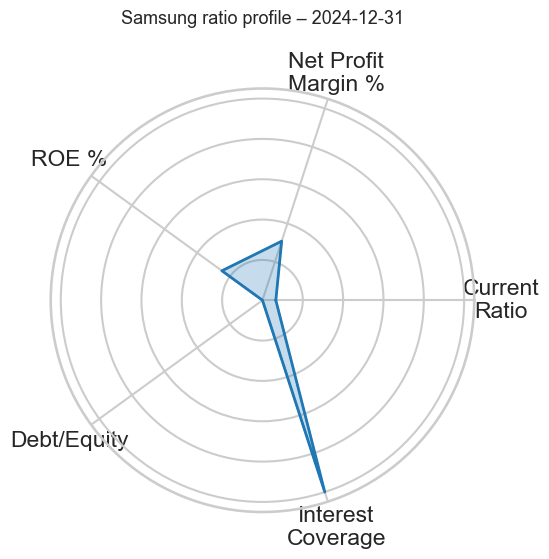

In [8]:
if not sub.empty:
    latest = sub.iloc[-1]
    label_period = sub.index[-1].strftime("%Y-%m-%d")

    # pick a few normalized dimensions
    radar_metrics = {
        "Current\nRatio": latest["Current_Ratio"],
        "Net Profit\nMargin %": 100 * latest["Net_Profit_Margin"],
        "ROE %": 100 * latest["ROE"],
        "Debt/Equity": latest["Debt_to_Equity"],
        "Interest\nCoverage": latest["Interest_Coverage"],
    }

    # simple min‑max normalization per axis for nicer shape
    vals = np.array(list(radar_metrics.values()), dtype=float)
    vals_norm = (vals - np.nanmin(vals)) / (np.nanmax(vals) - np.nanmin(vals) + 1e-9)

    labels = list(radar_metrics.keys())
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    vals_plot = vals_norm.tolist()
    vals_plot += vals_plot[:1]

    fig = plt.figure(figsize=(5.5, 5.5))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, vals_plot, color=palette[0], linewidth=2)
    ax.fill(angles, vals_plot, color=palette[0], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    ax.set_title(f"Samsung ratio profile – {label_period}", pad=20)
    plt.show()

# Financial Analysis – Samsung Electronics (005930.KS)

## Liquidity and Short-Term Strength

Samsung maintains a consistently strong liquidity position, with the current ratio ranging roughly between 2.4 and 2.8 and the quick ratio around 1.9–2.1 over the most recent four fiscal years. Even in the latest year, both ratios remain well above the conventional comfort threshold of 1.0, indicating a substantial buffer of short‑term assets over short‑term obligations and providing headroom to absorb short‑term revenue shocks or working‑capital swings. 

Key liquidity takeaways:
- **Both current and quick ratios are comfortably above 1**, suggesting that short‑term liabilities can be covered without relying on additional external funding. 
- **The slight softening in 2023–2024** (current ratio easing from the high‑2s towards the mid‑2s) still remains within a healthy band, and looks more like working‑capital optimisation than a sign of stress.  
- **Compared to many large tech peers that operate closer to 1–2×**, Samsung’s ratios reflect a more conservative liquidity stance and a preference for balance‑sheet strength. 

---

## Profitability Cycle

Profitability exhibits a clear cycle across the four‑year window: net profit margin and ROE are in the mid‑teens in 2021–2022, drop sharply in 2023 (NPM around 5–6% and ROE near 4%), and then recover in 2024 to a low‑double‑digit NPM and high‑single‑digit ROE. This trajectory aligns with the well‑documented downturn in the global memory and semiconductor market in 2023 and the subsequent recovery as pricing and demand improved in 2024. 

What this implies:
- **2021–2022 represent strong “through‑cycle” performance**, with solid margins and returns that are competitive within the global hardware and semiconductor space. 
- **2023 is clearly an outlier year driven by a cyclical shock**, not by structural deterioration in the business model, as evidenced by the quick rebound in margins and ROE in 2024.   
- **The 2024 ratios, while below the 2022 peak, already recapture a substantial portion of lost profitability**, indicating that the earnings power of the franchise remains intact.   

---

## Capital Structure and Solvency

Samsung operates with very low financial leverage, with the debt‑to‑equity ratio staying in a narrow band of roughly 0.02–0.05, meaning only a few cents of debt for every unit of equity on the balance sheet. Interest coverage is extremely comfortable, with operating income covering interest expense several dozen times in normal years and remaining well above common covenant thresholds even in the weak 2023 year.

Highlights of the capital structure:
- **Minimal reliance on debt financing** reduces refinancing risk and makes the company less exposed to interest‑rate cycles.
- **Very high interest‑coverage ratios** signal that fixed financing costs do not materially constrain strategic or operational flexibility, even in downturns.
- **Risk to creditors and long‑term solvency appears low**, supporting the view of Samsung as a conservative, balance‑sheet‑strong issuer in its sector. 

---

## DuPont Analysis – ROE Drivers

The DuPont breakdown indicates that asset turnover and the equity multiplier remain relatively stable over the period, while net profit margin is the primary driver behind swings in ROE. In particular, ROE’s sharp fall in 2023 and subsequent recovery in 2024 largely mirror the movement in NPM, while efficiency (asset turnover) and financial leverage (equity multiplier) move only modestly.  

Interpretation of ROE drivers:
- **ROE is earnings‑quality and margin‑driven rather than leverage‑driven**, which is preferable from a risk perspective.
- **Stable asset‑turnover ratios suggest that Samsung’s ability to generate revenue from its asset base is intact**, even through a difficult part of the cycle.
- **The equity multiplier remains low and steady**, confirming that management is not using aggressive leverage to boost reported returns to shareholders. 

---

## Overall Assessment

Overall, Samsung appears financially conservative and resilient: liquidity remains strong, leverage is minimal, and interest obligations are easily covered throughout both strong and weak years. The 2023 downturn looks like a cyclical earnings shock within an otherwise robust financial structure, with 2024 ratios already signalling a meaningful recovery in profitability without sacrificing the company’s low‑risk balance‑sheet profile.  

In summary:
- **Short‑term risk is low**, thanks to high current and quick ratios and ample coverage of near‑term liabilities.
- **Medium‑term earnings power remains attractive**, as evidenced by the rapid rebound in margins and ROE after the 2023 trough. 
- **The combination of strong liquidity, low leverage, and recovering profitability** positions Samsung well to navigate future industry cycles and to invest selectively in growth without over‑stretching its balance sheet.